In [61]:
!git clone https://github.com/HareeshwarKarthikeyan/Self-Driving-Car-with-Deep-Learning.git

fatal: destination path 'Self-Driving-Car-with-Deep-Learning' already exists and is not an empty directory.


In [62]:
!ls Self-Driving-Car-with-Deep-Learning

Data_after_equalising_initial.csv  driving_log.csv  IMG


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath

In [0]:
from imgaug import augmenters as iaa
import matplotlib.image as mpimg

In [0]:
datadir = 'Self-Driving-Car-with-Deep-Learning'

In [0]:
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names = columns)

In [67]:
data.head()

center  ...     speed
0  /Users/harry/Desktop/Data/IMG/center_2020_04_2...  ...  0.000078
1  /Users/harry/Desktop/Data/IMG/center_2020_04_2...  ...  0.000079
2  /Users/harry/Desktop/Data/IMG/center_2020_04_2...  ...  0.000078
3  /Users/harry/Desktop/Data/IMG/center_2020_04_2...  ...  0.000078
4  /Users/harry/Desktop/Data/IMG/center_2020_04_2...  ...  0.000078

[5 rows x 7 columns]

In [0]:
# we need only the tail end of the path for the images shown above
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [69]:
# plotting to steering angles see the distribution
num_bins = 25
hist,bins = np.histogram(data['steering'],num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


In [70]:
# centralising the values around 0
# do element wise addition to cancel out negatives at -0.04 + 0.04
# multiply by 0.5 to normalize
center = ( bins[:-1] + bins[1:] ) * 0.5
print(center)

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


<BarContainer object of 25 artists>

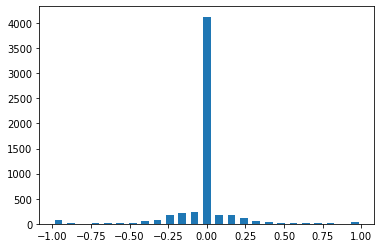

In [71]:
plt.bar(center,hist,width=0.05)
# steering angle of 0 found to have a very high frequency
# hence training the car with this data would tend to bias the car towards driving only straight

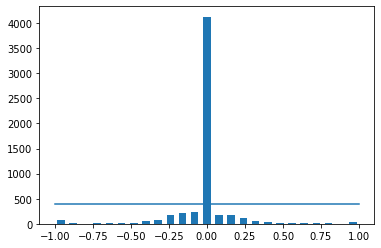

In [72]:
# reject all samples above a certain threshold say 400
samples_per_bin = 400
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [73]:
# removing the data points above the threshold of 400
# However this iterated through all the data points for a certain angle and say there are 500, they are iterated in order
      #   and in this case the 100 data points corresponding to that angle will be deleted which is pertaining to the end of the track
      #   hence we lose all data points corresponding to that training angle at the end of the track. 
      # Hence shuffle the data 
from sklearn.utils import shuffle
# but there are a lot more straight steering angles involved in actual driving process
# hence the number of samples for steering angle of 0 has to be high
# therefore set the threshold for the number of samples accordingly

print('Total Samples: ', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: 
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
      # above condition is for removing the samples that do not fall into any of the bins
data.drop(data.index[remove_list],inplace = True)
print('Removed Samples: ', len(remove_list))
print('Remaining Samples: ', len(data))
# now data is removed off the samples for the bins whose frequency is above 200

Total Samples:  5655
Removed Samples:  3729
Remaining Samples:  1926


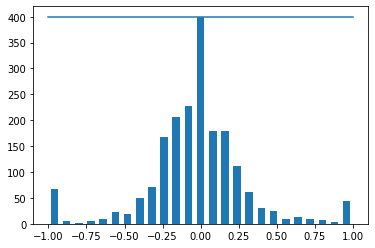

In [74]:
# plotting to visualise
hist, _  = np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [75]:
# getting images and the corresponding steering angles
print(data.iloc[1])
# steering value is found to be at index 3
def load_img_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[2],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths,steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_04_21_00_55_55_296.jpg
left          left_2020_04_21_00_55_55_296.jpg
right        right_2020_04_21_00_55_55_296.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                              7.84511e-05
Name: 16, dtype: object


In [0]:
from sklearn.model_selection import train_test_split

In [77]:
X_train,X_val,y_train,y_val = train_test_split(image_paths,steerings, test_size = 0.2,random_state = 6)
print(len(X_train))
print(len(X_val))

1540
386


Text(0.5, 1.0, 'Validation Set')

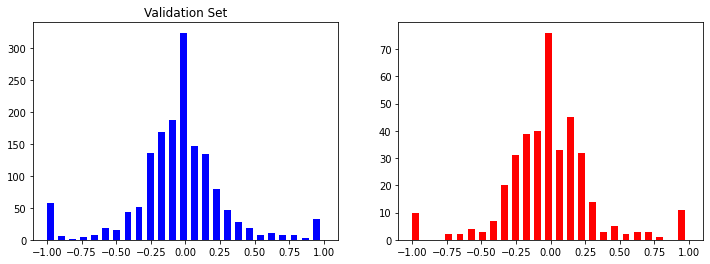

In [78]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins = num_bins,width = 0.05,color = 'blue')
axes[1].hist(y_val,bins = num_bins,width = 0.05,color = 'red')
axes[0].set_title('Training Set')
axes[0].set_title('Validation Set')

In [0]:
# IMAGE AUGMENTATION FUNCTIONS 

Text(0.5, 1.0, 'Zoomed Image')

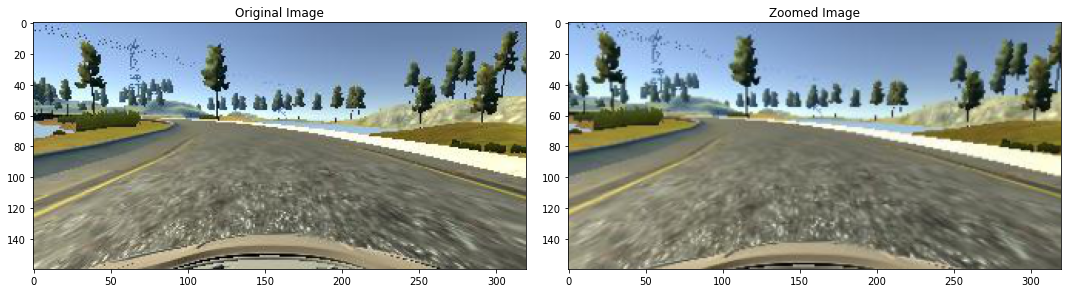

In [80]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) # zooming in till 0.3
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

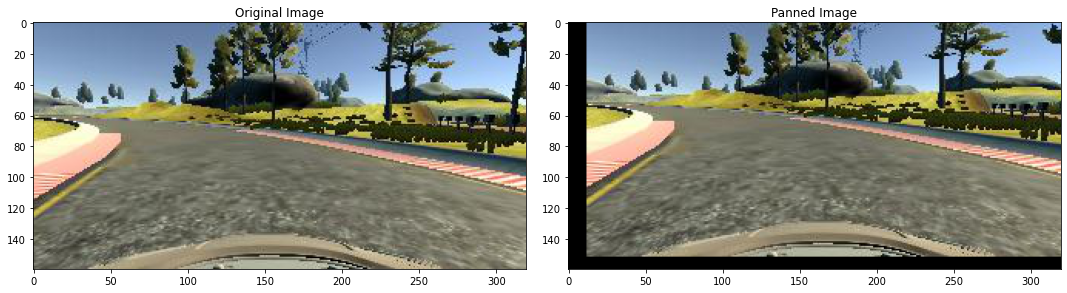

In [81]:
def pan(image): #for image translation
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

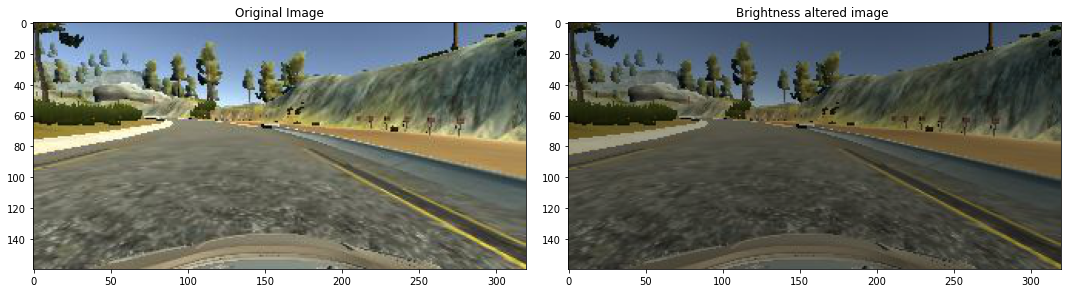

In [82]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2)) # brightness range from dimming to 0.2 to inc by 0.2
    image = brightness.augment_image(image)
    return image
    
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.204375')

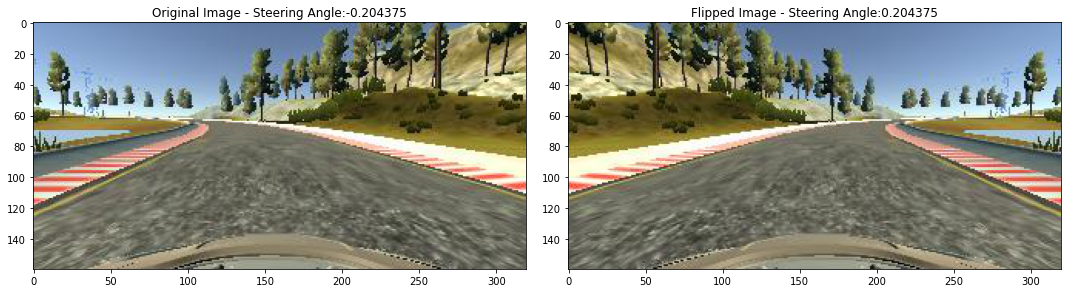

In [83]:

def img_random_flip(image, steering_angle): # flip the image and negate the steering angle to the other direction
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
# FUNCTION TO RANDOMISE THE AUGMENTATIONS APPLIED TO THE IMAGES
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    # 0.5 so that each augmentation is applied to only 50% of the images
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

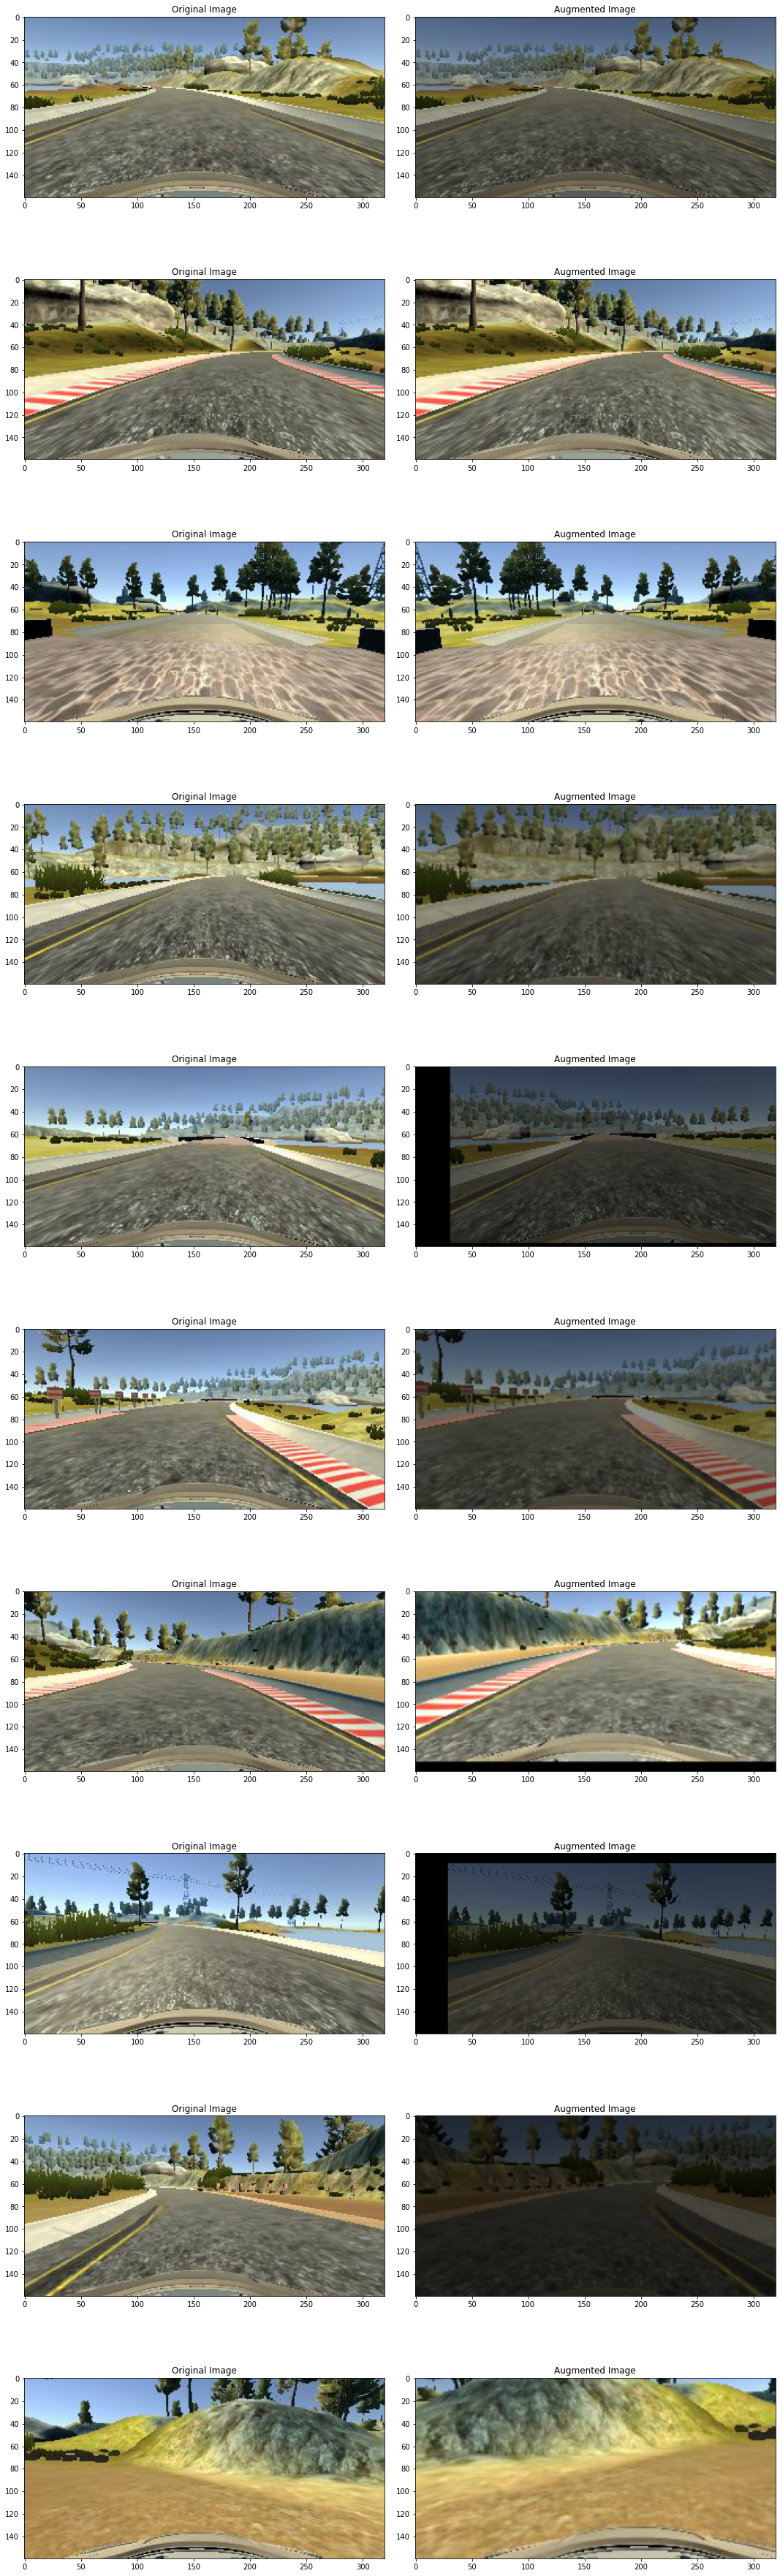

In [85]:
# Random augmentation for 10 random images
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
# Preprocessing the data
def img_preprocess(img):
  # cropping the unnecessary scenery part of the image as we need only the road by cropping the height
  img = img[60:135,:,:]
  # changing the color space of the image to yuv - y is luminosity and UV respresent the chrome val that adds color to the img
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  # reducing noise in the image
  img = cv2.GaussianBlur(img,(3,3),0)
  # make image size smaller for easier computation
  img = cv2.resize(img,(200,66))
  # normalising the image
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed_Image')

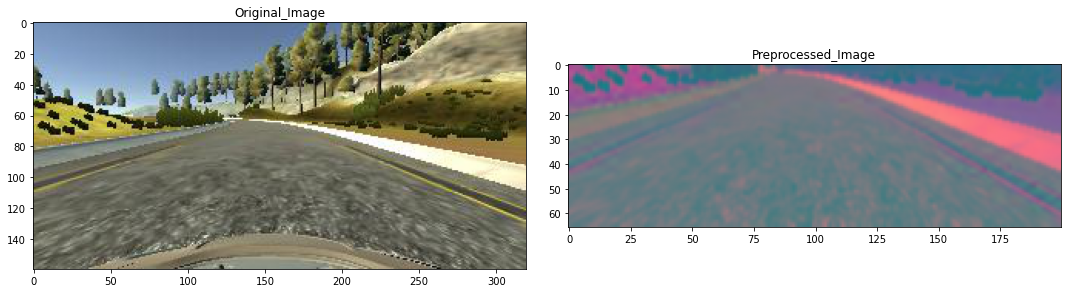

In [87]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
fig,axis = plt.subplots(1,2,figsize = (15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original_Image')
axis[1].imshow(preprocessed_image)
axis[1].set_title('Preprocessed_Image')

Text(0.5, 1.0, 'Validation Image')

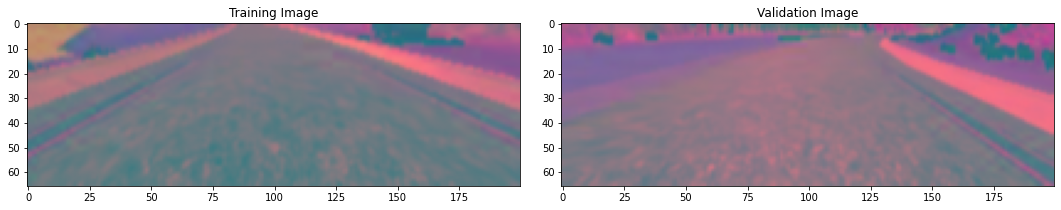

In [88]:
''' fit() requires the entire dataset as a numpy array in memory, 
which is why for larger datasets we make use of fit_generator, 
to generate augmented images on teh fly when needed and this is done in batches'''

def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_val_gen[0])
axs[1].set_title('Validation Image')

In [0]:
# an effective model for training self driving cars model 
def nvidia_model():

  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3), activation='relu'))
  
  # with relu a problem might occur called deal relu that feeds only 0 values to the next layer
  # enough number of dead relus will make the loss stagnant and will not decrease with epochs
  #  using elu activation which has a non zero gradient in the negative section instead of 0 in relu

  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  # model.add(Dropout(0.5))

  # when there were only two dropout layers
  # very low difference of 0.02 between the training and the validation loss
  # hence a decently good model is achieved
  # however the very low value of the loss means overfitting hence we have added more dropout layers  
  # but remove dropout layers when training loss is significantly greater than validation loss
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
  
  
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))
  
  
  optimizer= Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [90]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

In [91]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_val, y_val, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 219s 730ms/step - loss: 0.1076 - val_loss: 0.0492
Epoch 2/10
300/300 [==============================] - 215s 717ms/step - loss: 0.0868 - val_loss: 0.0700
Epoch 3/10
300/300 [==============================] - 215s 716ms/step - loss: 0.0811 - val_loss: 0.0595
Epoch 4/10
300/300 [==============================] - 211s 703ms/step - loss: 0.0788 - val_loss: 0.0580
Epoch 5/10
300/300 [==============================] - 210s 699ms/step - loss: 0.0738 - val_loss: 0.0846
Epoch 6/10
300/300 [==============================] - 210s 699ms/step - loss: 0.0725 - val_loss: 0.0362
Epoch 7/10
300/300 [==============================] - 209s 697ms/step - loss: 0.0699 - val_loss: 0.0707
Epoch 8/10
300/300 [==============================] - 213s 710ms/step - loss: 0.0660 - val_loss: 0.0309
Epoch 9/10
300/300 [==============================] - 208s 695ms/step - loss: 0.0642 - val_loss: 0.0627
Epoch 10/10
300/300 [==============================] - 213s 710m

Text(0.5, 0, 'epoch')

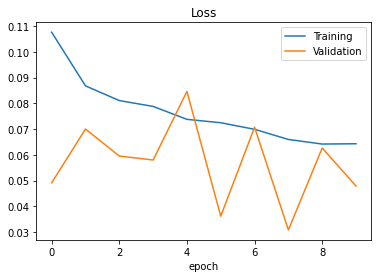

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('epoch')
# now it is seen that there is no overfitting

In [0]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')